In [8]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1708889449.1058795
Sun Feb 25 12:30:49 2024


In [9]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset


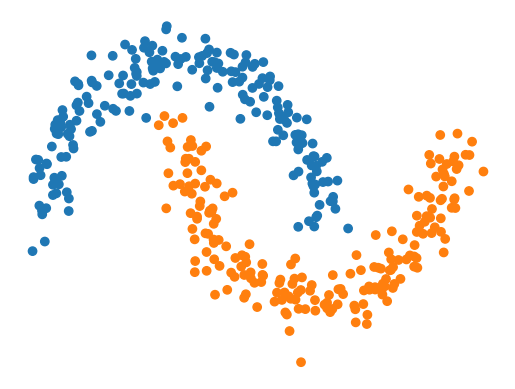

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(149)
np.random.seed(149)

X, y = make_moons(n_samples=400, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((400, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [11]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [12]:
import pennylane as qml

n_qubits = 10
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    H_layer(n_qubits)
    for i in range(n_layers//2):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    H_layer(n_qubits)
    qml.RandomLayers(weights, wires=range(n_qubits), ratio_imprim=0, rotations=[qml.RY], seed=149)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [17]:
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}

/tmp/ipykernel_2121533/2900486856.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


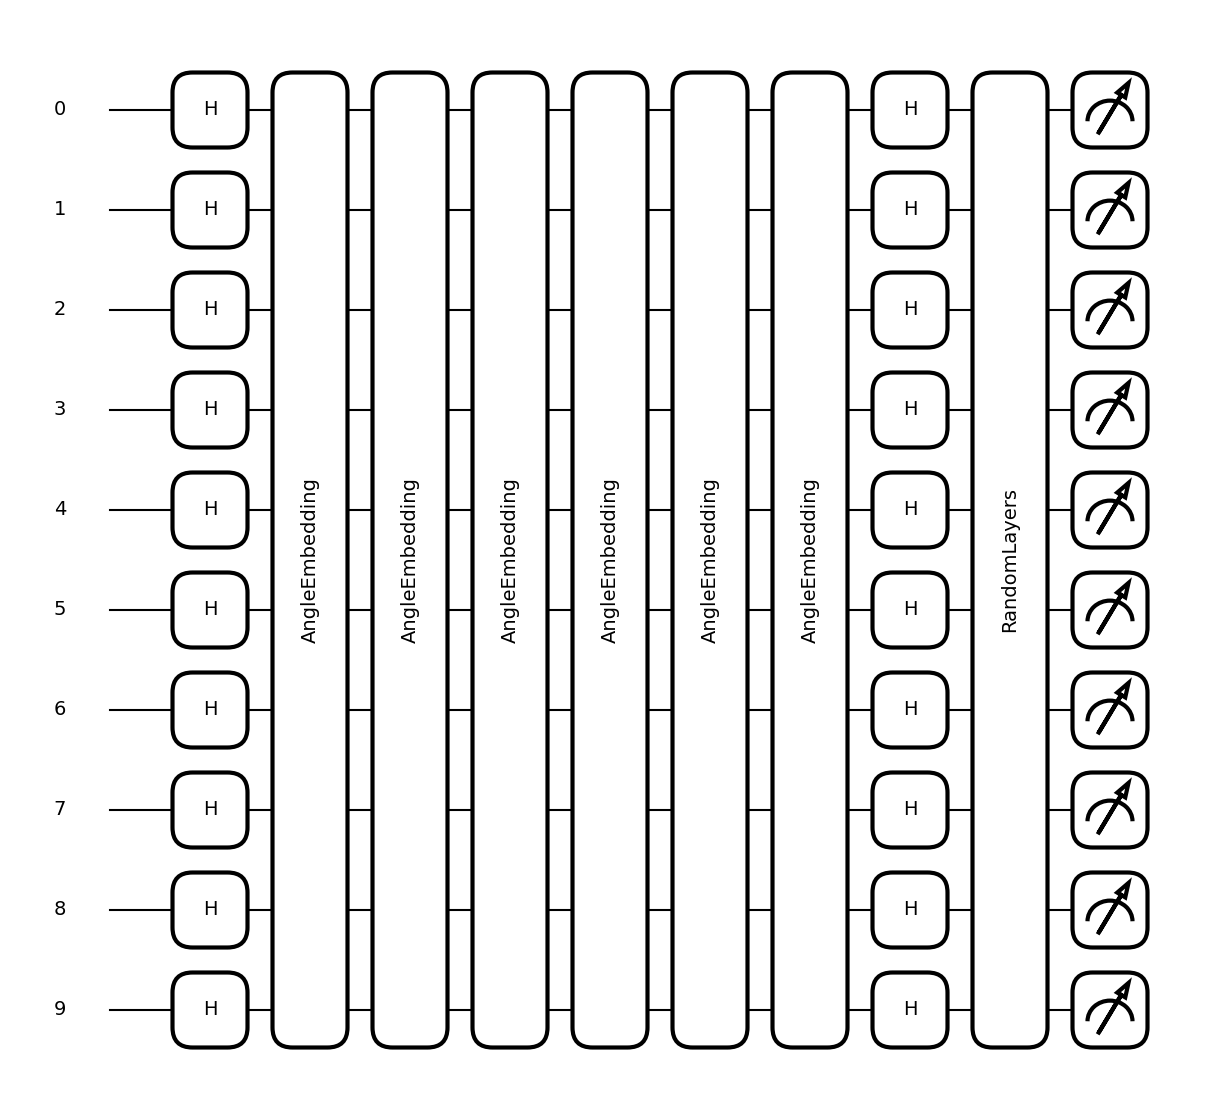

In [18]:
w = np.random.random(size=(n_layers, n_qubits))
fig, ax = qml.draw_mpl(qnode, show_all_wires=True, decimals=2)(w,w)
fig.show()

In [19]:
print(qml.draw(qnode, expansion_strategy="device")(w,w))

0: ──H──RY(M0)──RZ(M0)──RY(M0)──RY(M0)──RZ(M0)──RY(M0)──H──RY(0.26)──RY(0.64)──RY(0.89)──RY(0.52)
1: ──H──RY(M1)──RZ(M1)──RY(M1)──RY(M1)──RZ(M1)──RY(M1)──H──RY(0.51)──RY(0.04)──RY(0.88)──RY(0.33)
2: ──H──RY(M2)──RZ(M2)──RY(M2)──RY(M2)──RZ(M2)──RY(M2)──H──RY(0.03)──RY(0.59)──RY(0.04)──RY(0.62)
3: ──H──RY(M3)──RZ(M3)──RY(M3)──RY(M3)──RZ(M3)──RY(M3)──H──RY(0.32)──RY(0.16)──RY(0.90)──RY(0.51)
4: ──H──RY(M4)──RZ(M4)──RY(M4)──RY(M4)──RZ(M4)──RY(M4)──H──RY(0.37)──RY(0.84)──RY(0.97)──RY(0.60)
5: ──H──RY(M5)──RZ(M5)──RY(M5)──RY(M5)──RZ(M5)──RY(M5)──H──RY(0.44)──RY(0.54)──RY(0.92)──RY(0.16)
6: ──H──RY(M6)──RZ(M6)──RY(M6)──RY(M6)──RZ(M6)──RY(M6)──H──RY(0.28)──RY(0.69)──RY(0.17)──RY(0.99)
7: ──H──RY(M7)──RZ(M7)──RY(M7)──RY(M7)──RZ(M7)──RY(M7)──H──RY(0.98)──RY(0.64)──RY(0.04)──────────
8: ──H──RY(M8)──RZ(M8)──RY(M8)──RY(M8)──RZ(M8)──RY(M8)──H──RY(0.57)──RY(0.94)──RY(0.25)──RY(0.84)
9: ──H──RY(M9)──RZ(M9)──RY(M9)──RY(M9)──RZ(M9)──RY(M9)──H──RY(0.40)──RY(0.54)──RY(0.78)──RY(0.35)

───────────────────

In [20]:
loss_func = torch.nn.L1Loss()

In [21]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 20)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(20, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 10, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, requires_grad=True).float()
y_ = torch.unsqueeze(torch.tensor(y_train), 1)  # used for one-hot encoded labels
y_train_hot = torch.scatter(torch.zeros((280, 2)), 1, y_, 1)
y_train_hot = y_train_hot.float()

X_test = torch.tensor(X_test, requires_grad=True).float()
y_ = torch.unsqueeze(torch.tensor(y_test), 1)  # used for one-hot encoded labels
y_test_hot = torch.scatter(torch.zeros((120, 2)), 1, y_, 1)
y_test_hot = y_test_hot.float()

train_dataset = TensorDataset(X_train, y_train_hot)
test_dataset = TensorDataset(X_test, y_test_hot)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, drop_last=True)

opt = torch.optim.SGD(model.parameters(), lr=0.52)

train_acc_history = []
test_acc_history = []

epochs = 40

for epoch in range(epochs):
    train_running_loss = 0
    test_running_loss = 0
    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()
        
    train_avg_loss = train_running_loss / batches

    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")

    # Calculate train accuracy
    y_pred_train = model(X_train)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y_train)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_acc_history.append(train_accuracy)
    
    # Calculate testmodel.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
        correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y_test)]
        test_accuracy = sum(correct_test) / len(correct_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        test_acc_history.append(test_accuracy)
    

/tmp/ipykernel_2121533/1585914263.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, requires_grad=True).float()
/tmp/ipykernel_2121533/1585914263.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, requires_grad=True).float()


Train - Epoch 1: Loss: 0.1410
Train Accuracy: 98.57%
Test Accuracy: 98.33%
Train - Epoch 2: Loss: 0.0278
Train Accuracy: 99.29%
Test Accuracy: 100.00%
Train - Epoch 3: Loss: 0.0276
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 4: Loss: 0.0360
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 5: Loss: 0.0208
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 6: Loss: 0.0304
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 7: Loss: 0.0218
Train Accuracy: 99.29%
Test Accuracy: 100.00%
Train - Epoch 8: Loss: 0.0189
Train Accuracy: 99.64%
Test Accuracy: 98.33%
Train - Epoch 9: Loss: 0.0213
Train Accuracy: 99.64%
Test Accuracy: 100.00%
Train - Epoch 10: Loss: 0.0104
Train Accuracy: 98.93%
Test Accuracy: 99.17%
Train - Epoch 11: Loss: 0.0104
Train Accuracy: 100.00%
Test Accuracy: 100.00%
Train - Epoch 12: Loss: 0.0194
Train Accuracy: 98.93%
Test Accuracy: 100.00%
Train - Epoch 13: Loss: 0.0234
Train Accuracy: 95.36%
Test Accuracy: 96.67%
Train - Epoch 1

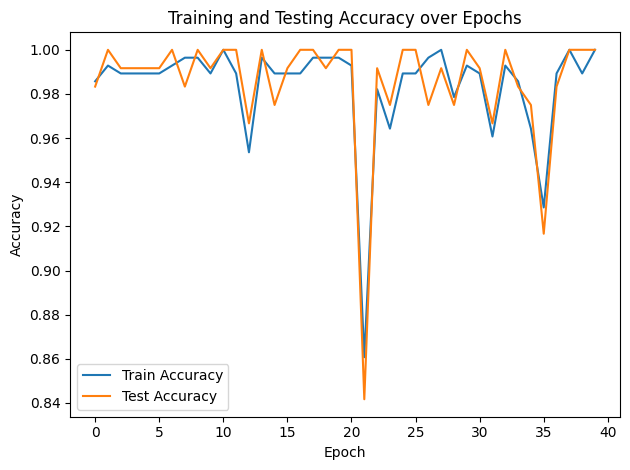

In [24]:
# Plotting the training and testing accuracies
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')
plt.tight_layout()
plt.show()

In [41]:
# Generate mesh grid covering the feature space
# Creating a meshgrid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

In [42]:
mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

In [47]:
Z = predictions_train.reshape(xx.shape)

ValueError: cannot reshape array of size 280 into shape (310,429)

In [37]:
# Predict class for each point in the grid
Z = predictions_train.reshape(xx.shape)

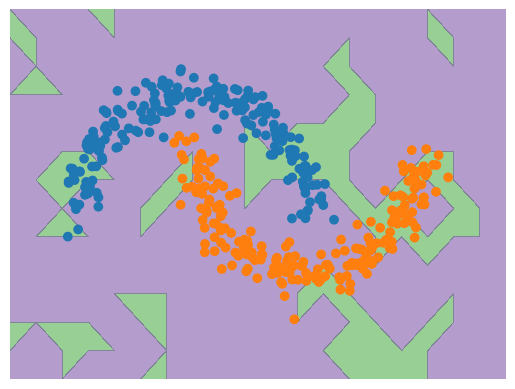

In [38]:
# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.5, levels=np.arange(-1, 2), cmap=plt.cm.Paired, zorder=-1)

# Overlay the original dataset
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # Colours for each class
plt.scatter(X[:, 0], X[:, 1], c=c, zorder=0)

plt.axis("off")
plt.show()

About the author
================


In [9]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1708813854.662059
Sat Feb 24 15:30:54 2024
